# Preprocessing

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

[Info] Deskewing: Rotated image by -90.00 degrees


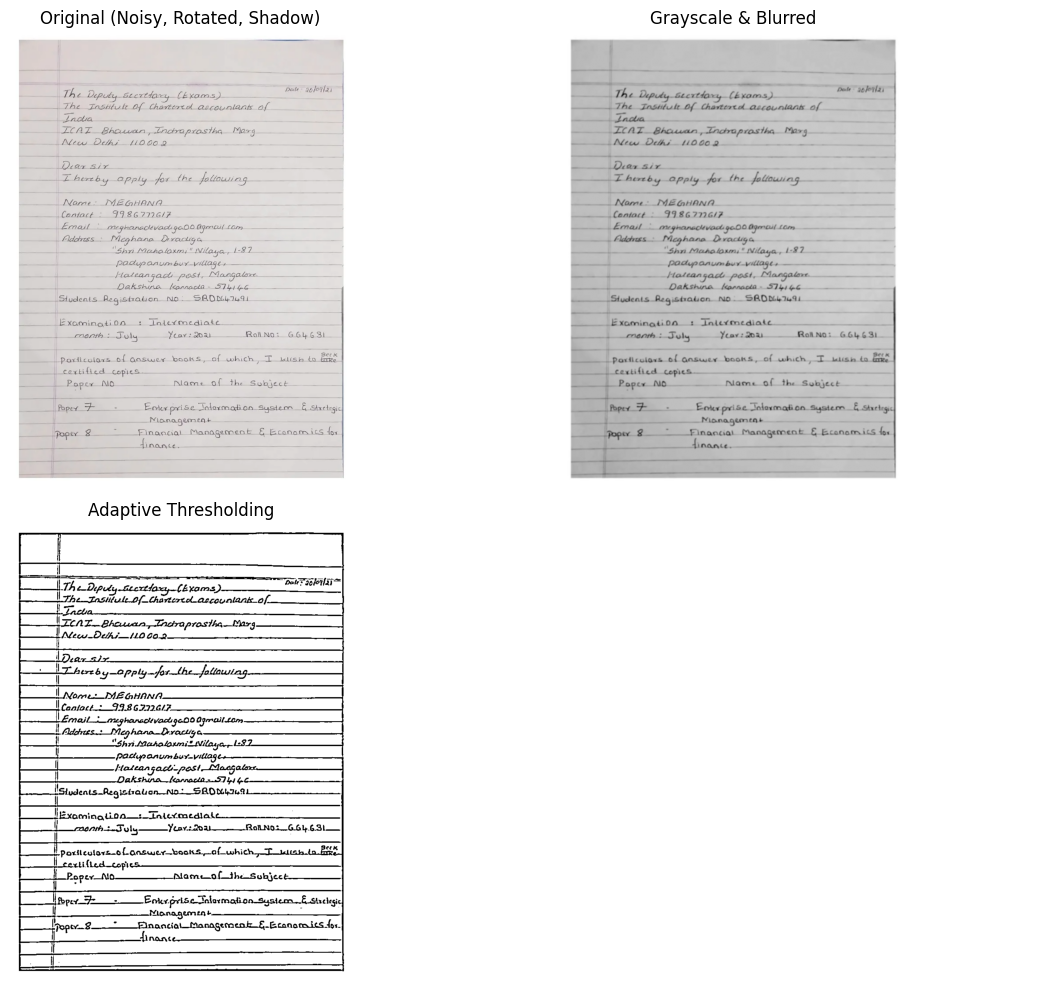

Pipeline Complete. Ready for Tesseract.


In [46]:
class OCRPreprocessor:
    def __init__(self, debug=False):
        self.debug = debug

    def display(self, title, image, cmap='gray'):
        if self.debug:
            plt.figure(figsize=(10, 6))
            plt.imshow(image, cmap=cmap)
            plt.title(title)
            plt.axis('off')
            plt.show()

    def get_grayscale(self, image):
        """
        Converts image to grayscale.
        Why: OCR engines work best on high-contrast black and white.
        Color information is usually noise in text recognition.
        """
        if len(image.shape) == 3:
            return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return image

    def remove_noise(self, image):
        """
        Applies Gaussian Blur to smooth out edges and remove salt-and-pepper noise.
        """
        return cv2.GaussianBlur(image, (5, 5), 0)

    def thresholding(self, image):
        """
        Applies Adaptive Thresholding.
        Why: Unlike global thresholding, adaptive handles shadows and
        uneven lighting (like a photo of a page) much better.
        """
        # ADAPTIVE_THRESH_GAUSSIAN_C calculates threshold based on neighbors
        # Block Size: 11 (neighborhood size), C: 2 (constant subtracted from mean)
        return cv2.adaptiveThreshold(
            image, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, 11, 2
        )

    def morphological_operations(self, image):
        """
        Applies Opening (Erosion followed by Dilation).
        Why: Removes small white dots (noise) from the black background
        and detaches connected characters.
        """
        kernel = np.ones((1, 1), np.uint8)
        # Opening: Erosion -> Dilation
        opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
        # Closing: Dilation -> Erosion (Good for filling small holes inside letters)
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
        return closing

    def deskew(self, image):
        """
        Detects the skew angle of the text and rotates it back to horizontal.
        Why: OCR engines read left-to-right. Tilted text drastically lowers accuracy.
        """
        coords = np.column_stack(np.where(image > 0))
        angle = cv2.minAreaRect(coords)[-1]

        # Adjust angle format for cv2.minAreaRect
        if angle < -45:
            angle = -(90 + angle)
        else:
            angle = -angle

        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)

        # Rotation Matrix
        M = cv2.getRotationMatrix2D(center, angle, 1.0)

        # Rotate
        rotated = cv2.warpAffine(
            image, M, (w, h),
            flags=cv2.INTER_CUBIC,
            borderMode=cv2.BORDER_REPLICATE
        )

        print(f"[Info] Deskewing: Rotated image by {angle:.2f} degrees")
        return rotated

    def process(self, image):
        """
        Runs the full pipeline.
        """
        steps = {}

        # 1. Grayscale
        gray = self.get_grayscale(image)
        steps['1_Grayscale'] = gray

        # 2. Denoise (Blur)
        blur = self.remove_noise(gray)
        steps['2_Blurred'] = blur

        # 3. Threshold (Binarize)
        # Note: We invert because contours/deskew often work better on white-on-black,
        # but Tesseract prefers black-text-on-white.
        thresh = self.thresholding(blur)
        steps['3_Threshold'] = thresh

        # 4. Deskew (requires checking the binary image)
        # We invert for deskew calculation (text becomes white, background black)
        inverted_thresh = cv2.bitwise_not(thresh)
        rotated = self.deskew(inverted_thresh)

        # Re-invert back to black text on white background for OCR
        final_image = cv2.bitwise_not(rotated)
        steps['4_Deskewed_Final'] = final_image

        return final_image, steps

# To Generate Mock Data for Testing
def create_mock_document():
    # Create a white background
    img = np.ones((600, 800, 3), dtype=np.uint8) * 255

    # Add Text
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, "INVOICE #12345", (100, 150), font, 1.5, (0, 0, 0), 3)
    cv2.putText(img, "Total: $500.00", (100, 250), font, 1.2, (50, 50, 50), 2)
    cv2.putText(img, "Date: 2023-10-27", (100, 350), font, 1.2, (50, 50, 50), 2)

    # Add Salt and Pepper Noise
    noise = np.random.randint(0, 2, (600, 800))
    img[noise == 0] = 240 # Light grey noise

    # Add a shadow (gradient)
    x = np.arange(800)
    y = np.arange(600)
    X, Y = np.meshgrid(x, y)
    shadow = (X + Y) / 2000
    img = img * (1 - shadow[:, :, None] * 0.3)
    img = img.astype(np.uint8)

    # Rotate the image to simulate a bad scan
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, 5, 1.0) # Rotate 5 degrees
    img_rotated = cv2.warpAffine(img, M, (w, h), borderValue=(255,255,255))

    return img_rotated

# Main funtion
if __name__ == "__main__":
    # 1. Input image
        # To Generate Mock Image
          #original_image = create_mock_document()

    original_image = cv2.cvtColor(cv2.imread("/content/1678244047.webp"), cv2.COLOR_BGR2RGB)

    # 2. Initialize Processor
    processor = OCRPreprocessor(debug=False)

    # 3. Run Pipeline
    final_result, steps = processor.process(original_image)

    # 4. Visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    ax = axes.ravel()

    ax[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original (Noisy, Rotated, Shadow)")

    ax[1].imshow(steps['2_Blurred'], cmap='gray')
    ax[1].set_title("Grayscale & Blurred")

    ax[2].imshow(steps['3_Threshold'], cmap='gray')
    ax[2].set_title("Adaptive Thresholding")

    #ax[3].imshow(final_result, cmap='gray')
    #ax[3].set_title("Final: Deskewed & Cleaned")

    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

    print("Pipeline Complete. Ready for Tesseract.")